For each practical exercise (TP), please work in groups of two or three. Then, create a **private GitHub repository** and add me (my GitHub is **arthur-75**) to your project. Finally, share the link to your project (or TP) under  [Practical Exercises](https://docs.google.com/spreadsheets/d/1V-YKgHn71FnwjoFltDhWsPJS7uIuAh9lj6SP2DSCvlY/edit?usp=sharing) and make sure to choose your **team name** :-)

## **Flows based Models using RealNVP**



### **Understanding Normalizing Flows (NF)**

Normalizing Flows are generative models used to:

* Model complex data distributions by applying an invertible transformation to a simple base distribution (e.g., Gaussian).  
* Evaluate exact likelihoods through the change of variables formula.  
* Generate new samples by applying the inverse transformation to samples drawn from the simple base distribution.

A Normalizing Flow consists of a series of invertible and differentiable mappings:  
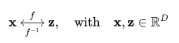 

We define the **log-likelihood** of the data x\\mathbf{x}x using a change of variables:   
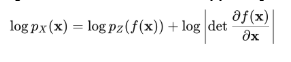

### **RealNVP – the Theory**

RealNVP simplifies Normalizing Flows by using a coupling layer architecture. This structure ensures invertibility and efficient computation of the Jacobian determinant.

A RealNVP coupling layer partitions the input data x\\mathbf{x}x into two parts: xa\\mathbf{x}\_axa​ and xb\\mathbf{x}\_bxb​:

* xa​ remains unchanged.  
* xb is transformed based on parameters computed from xa​.

#### **Forward pass (data → latent space):**

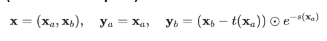

#### **Inverse pass (latent space → data):**

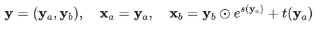

* Functions s(⋅) and t(⋅) are neural networks called **scale** and **translation** networks.  
* ⊙ denotes element-wise multiplication.

#### **Jacobian Determinant:**

The Jacobian of a RealNVP coupling layer is a lower-triangular block matrix whose determinant simplifies dramatically:

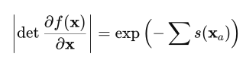

This efficient computation is a key advantage of RealNVP.

## **Dataset Preparation (Moon Dataset)**

* Generate synthetic data   
* Normalize dataset


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Hyperparameters
INPUT_DIM = 2
COUPLING_DIM = 256
COUPLING_LAYERS = 4
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
class MoonsDataset(Dataset):
    def __init__(self, n_samples=30000, noise=0.05):
        data, _ = make_moons(n_samples=n_samples, noise=noise)
        self.data = ((data - data.mean(0)) / data.std(0)).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]




## **RealNVP Architecture**

RealNVP consists of multiple coupling layers with alternating masks:

* Alternate masks: e.g. \[0,1\], \[1,0\], to alternate transformed dimensions.  
* Use multiple coupling layers to increase modeling power.

### **Forward pass (data → latent):**

* Iteratively pass input through coupling layers.  
* Calculate cumulative log-determinant of Jacobians.

### **Inverse pass (latent → data, for sampling):**

* Reverse direction through coupling layers.  
* No log-determinant calculation required during sampling.

## **Training Procedure**

**Goal:** Maximize the likelihood (or equivalently minimize negative log-likelihood)

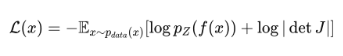

* Optimize with Adam optimizer.  
* Use PyTorch for automatic differentiation.


In [11]:

# Corrected Coupling Layer
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2), nn.Tanh())

        self.translate_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2))

    def forward(self, x, mask, reverse=False):
        x_a = x * mask
        x_b = x * (1 - mask)

        # Pass only x_a's non-zero dimensions to the networks
        x_a_cond = x_a[:, mask.bool()]
        
        s = self.scale_net(x_a_cond)
        t = self.translate_net(x_a_cond)

        if not reverse:
            y_b = (x_b[:, (1 - mask).bool()] * torch.exp(s)) + t
            log_det_jac = s.sum(dim=1)
        else:
            y_b = (x_b[:, (1 - mask).bool()] - t) * torch.exp(-s)
            log_det_jac = -s.sum(dim=1)

        # Reconstruct the output
        y = torch.zeros_like(x)
        y[:, mask.bool()] = x_a_cond
        y[:, (1 - mask).bool()] = y_b

        return y, log_det_jac


# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows):
        super().__init__()
        self.prior = torch.distributions.MultivariateNormal(torch.zeros(input_dim).to(DEVICE), torch.eye(input_dim).to(DEVICE))
        self.layers = nn.ModuleList([CouplingLayer(input_dim, hidden_dim) for _ in range(num_flows)])
        self.masks = [torch.tensor([i % 2, (i+1) % 2]).float().to(DEVICE) for i in range(num_flows)]

    def forward(self, x):
        log_det_J = 0
        for layer, mask in zip(self.layers, self.masks):
            x, log_det = layer(x, mask)
            log_det_J += log_det
        return x, log_det_J

    def loss(self, x):
        z, log_det_J = self(x)
        log_prob = self.prior.log_prob(z)
        return -(log_det_J + log_prob).mean()

    def sample(self, num_samples):
        z = self.prior.sample((num_samples,))
        for layer, mask in reversed(list(zip(self.layers, self.masks))):
            z, _ = layer(z, mask, reverse=True)
        return z



## **Training Loop:**

* Iterate over epochs.  
* For each batch:  
  * Compute loss.  
  * Backpropagation and parameter updates.  
* Use `tqdm` for progress bar visualization and live feedback on loss.


In [12]:

def train(model, loader, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        tqdm_loader = tqdm(loader, desc=f"Training RealNVP - Epoch {epoch+1}/{epochs}")

        for batch in tqdm_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            loss = model.loss(batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            tqdm_loader.set_postfix(loss=loss.item())

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {total_loss:.6f} ")


## **Sampling Procedure:**

To generate new samples:

1. Draw samples z ∼ N(0,I).  
2. Transform samples via inverse coupling layers to data space.

## **Visualization:**

* Visualize sampled data and original dataset to qualitatively evaluate the model.  
* Use scatter plots for clear representation.


Training RealNVP - Epoch 1/5: 100%|██████████| 118/118 [00:02<00:00, 50.68it/s, loss=2.34]


Epoch [1/5], Train Loss: 285.527266 


Training RealNVP - Epoch 2/5: 100%|██████████| 118/118 [00:02<00:00, 51.51it/s, loss=1.93]


Epoch [2/5], Train Loss: 248.176583 


Training RealNVP - Epoch 3/5: 100%|██████████| 118/118 [00:02<00:00, 49.18it/s, loss=1.81]


Epoch [3/5], Train Loss: 224.890559 


Training RealNVP - Epoch 4/5: 100%|██████████| 118/118 [00:02<00:00, 45.43it/s, loss=1.82]


Epoch [4/5], Train Loss: 212.343743 


Training RealNVP - Epoch 5/5: 100%|██████████| 118/118 [00:03<00:00, 37.80it/s, loss=1.93]


Epoch [5/5], Train Loss: 203.659177 


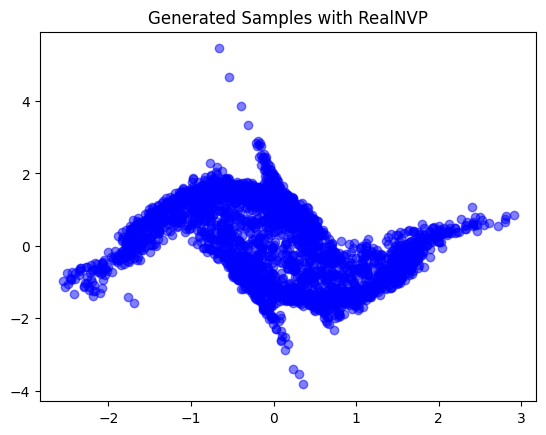

In [13]:
dataset = MoonsDataset()
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = RealNVP(INPUT_DIM, COUPLING_DIM, COUPLING_LAYERS).to(DEVICE)

train(model, loader, EPOCHS, LR)

# Sampling
samples = model.sample(3000).cpu().detach().numpy()

plt.scatter(samples[:,0], samples[:,1], alpha=0.5, color='blue')
plt.title('Generated Samples with RealNVP')
plt.show()

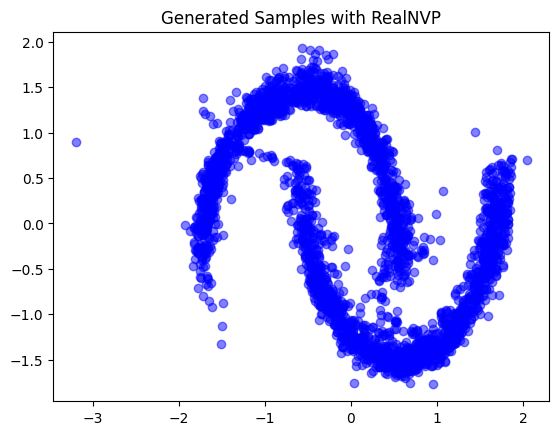

In [9]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, color='blue')
plt.title('Generated Samples with RealNVP')
plt.show()